# Time Series Prediction


In [1]:
# @ Lukman copyright 
# MIT Licence

In [2]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *
from tensorflow.keras import regularizers

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

In [3]:
import sys

In [4]:
sys.executable

'/home/cat/anaconda3/envs/cat/bin/python'

In [5]:
# enable eager executinon
tf.enable_eager_execution()

In [6]:
tf.__version__

'1.15.0'

# Data Preprocessing 

In [7]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
meterOneDataLOaded= pd.read_csv('meterOneTrainData.csv')
# all meter types data set could be analysed in same manner

In [8]:
meterOneDataLOaded[1:3]

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,1,162,1,2016-01-01 00:00:00,0.0000,2,Education,98829,1968.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2,2,163,1,2016-01-01 00:00:00,4.5719,2,Education,72102,1970.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6


In [9]:
# delete column unnmaed
del meterOneDataLOaded['Unnamed: 0']

In [10]:
# column values 
meterOneDataLOaded.columns.tolist()

['building_id',
 'meter',
 'timestamp',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [11]:
# store column as list
columns = meterOneDataLOaded.columns.tolist()

In [12]:
# get null values per column in the data set
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [13]:
# chnage to time sta
meterOneDataLOaded['timestamp'] =  pd.to_datetime(meterOneDataLOaded['timestamp'])


In [14]:
# check the unique time stamp present
pd.DatetimeIndex(meterOneDataLOaded['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [15]:
meterOneDataLOaded.dtypes

building_id                    int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [16]:
# choose windpseed because it has fewer null values
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [17]:
# set time stamp as index 
meterOneDataLOaded.set_index('timestamp',inplace=True);


In [18]:
meterOneDataLOaded['dew_temperature'][1:2]

timestamp
2016-01-01   -5.6
Name: dew_temperature, dtype: float64

#### Model 


In [19]:
# a subset of the data has been copied to use to test the visualizer function
# use the full data set if space is available and system is fast

train_test = meterOneDataLOaded[['building_id','meter_reading', 'square_feet', 'air_temperature','primary_use','site_id','dew_temperature']][1:40000].copy()


In [20]:

# reset the index so that time is no longer the index
# the index is now  numbers 
train_test.reset_index(level=0, inplace=True)


In [21]:
# only 2016 data is represented here as usual
pd.DatetimeIndex(train_test['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [22]:
# extrac year month and day
train_test['year'] = pd.DatetimeIndex(train_test['timestamp']).year
train_test['month'] = pd.DatetimeIndex(train_test['timestamp']).month
train_test['day'] = pd.DatetimeIndex(train_test['timestamp']).day
train_test['hour'] = pd.DatetimeIndex(train_test['timestamp']).hour


In [23]:
# check null values
train_test.isnull().sum()

timestamp             0
building_id           0
meter_reading         0
square_feet           0
air_temperature    2536
primary_use           0
site_id               0
dew_temperature    2536
year                  0
month                 0
day                   0
hour                  0
dtype: int64

In [24]:
# check data types
train_test.dtypes

timestamp          datetime64[ns]
building_id                 int64
meter_reading             float64
square_feet                 int64
air_temperature           float64
primary_use                object
site_id                     int64
dew_temperature           float64
year                        int64
month                       int64
day                         int64
hour                        int64
dtype: object

In [25]:
# forward filling missing values since values from previous timestamp should
# ideally be similar to the next one. (temperature today and tomorrow should be quite similar)
train_test['air_temperature'].fillna(method='ffill', inplace=True)
train_test['dew_temperature'].fillna(method='ffill', inplace=True)

In [26]:
# delete year we wont use the year information in the model
del train_test['year']

In [27]:
# encode site id and primary use
train_test = pd.get_dummies(train_test, columns=["primary_use","site_id"])

In [28]:
# there are 8908 meter readings with value of zero. let us remove those
train_test[train_test['meter_reading'] <= 0.]['meter_reading'].count() 

11743

In [29]:
# remove columns with meter readings of zero
train_test = train_test[train_test.meter_reading != 0]

In [30]:

train_test[train_test['meter_reading'] <= 0.]['meter_reading'].count() 

0

In [31]:
train_test.head()

,timestamp,building_id,meter_reading,square_feet,air_temperature,dew_temperature,month,day,hour,primary_use_Education,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
1,2016-01-01,163,4.5719,72102,15.6,-5.6,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2016-01-01,166,209.8860,553210,15.6,-5.6,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2016-01-01,168,51.5570,183460,15.6,-5.6,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
5,2016-01-01,169,176.6860,179559,15.6,-5.6,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
6,2016-01-01,170,11.2891,45224,15.6,-5.6,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [32]:
# set time as index
train_test.set_index('timestamp',inplace=True);


In [33]:
train_test[1:2]

,building_id,meter_reading,square_feet,air_temperature,dew_temperature,month,day,hour,primary_use_Education,primary_use_Entertainment/public assembly,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,166,209.886,553210,15.6,-5.6,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
col_names = list(train_test.columns)[1:]

In [35]:
col_names

['meter_reading',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'month',
 'day',
 'hour',
 'primary_use_Education',
 'primary_use_Entertainment/public assembly',
 'primary_use_Food sales and service',
 'primary_use_Healthcare',
 'primary_use_Lodging/residential',
 'primary_use_Manufacturing/industrial',
 'primary_use_Office',
 'primary_use_Other',
 'primary_use_Parking',
 'primary_use_Public services',
 'primary_use_Religious worship',
 'primary_use_Retail',
 'primary_use_Technology/science',
 'primary_use_Utility',
 'site_id_2',
 'site_id_6',
 'site_id_7',
 'site_id_9',
 'site_id_10',
 'site_id_11',
 'site_id_13',
 'site_id_14',
 'site_id_15']

In [36]:
# save the data types 
data_types = list(train_test.dtypes)[1:]

In [37]:
data_types

[dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8')]

In [38]:
# convert the data types to 
# tensorflow data types 
for i,j in enumerate(data_types):
    j = str(j) # convertr from numpy dtype to str
    #print(j)
    if j == 'float64':
        data_types[i] = tf.float64
    else:
        data_types[i]  = tf.int32

### Extract the predictor and featues

In [39]:
# separate test train
test = train_test.tail(1000).copy(deep=True)
train_= train_test.shape[0]-test.shape[0] # train partition
train = train_test[:train_].copy(deep=True)

In [40]:
# x axis for test values needed for plots
test_timestamp = list(test.index.values)
test_building_id = list(test.building_id.values)

In [41]:
del test['building_id']
del train['building_id']

In [42]:
# convert to csv
# used for a lodal that can preserve the data type
# note that the index has been ignored here
train.to_csv('meter1.csv',index=False,header=None)
test.to_csv('meter1Test.csv',index=False,header=None)


#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [43]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset('meter1.csv', data_types, header=False)

In [44]:
# check the data type :
print(list(csvData.take(1)))

[(<tf.Tensor: id=47, shape=(), dtype=float64, numpy=4.5719>, <tf.Tensor: id=48, shape=(), dtype=int32, numpy=72102>, <tf.Tensor: id=49, shape=(), dtype=float64, numpy=15.6>, <tf.Tensor: id=50, shape=(), dtype=float64, numpy=-5.6>, <tf.Tensor: id=51, shape=(), dtype=int32, numpy=1>, <tf.Tensor: id=52, shape=(), dtype=int32, numpy=1>, <tf.Tensor: id=53, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=54, shape=(), dtype=int32, numpy=1>, <tf.Tensor: id=55, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=56, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=57, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=58, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=59, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=60, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=61, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=62, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=63, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=64, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=65, shape=(), dtype=int32,

In [45]:
col_names

['meter_reading',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'month',
 'day',
 'hour',
 'primary_use_Education',
 'primary_use_Entertainment/public assembly',
 'primary_use_Food sales and service',
 'primary_use_Healthcare',
 'primary_use_Lodging/residential',
 'primary_use_Manufacturing/industrial',
 'primary_use_Office',
 'primary_use_Other',
 'primary_use_Parking',
 'primary_use_Public services',
 'primary_use_Religious worship',
 'primary_use_Retail',
 'primary_use_Technology/science',
 'primary_use_Utility',
 'site_id_2',
 'site_id_6',
 'site_id_7',
 'site_id_9',
 'site_id_10',
 'site_id_11',
 'site_id_13',
 'site_id_14',
 'site_id_15']

#### Parse data 

In [46]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],'month_day','primary_use','site_id' ]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[21:30])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features, targets_tensor

##### Batch the datatset

In [47]:

dataset = csvData.map(_parse_csv_row).batch(64)

In [48]:

print(list(dataset.take(1)))

[({'square_feet': <tf.Tensor: id=135, shape=(64,), dtype=int32, numpy=
array([ 72102, 553210, 183460, 179559,  45224,  90903,  90900, 111635,
       167066,  23392,  24867,  24586, 148829, 132518,  44203,  23549,
        78268, 151637, 155682,   9703, 102856, 163959, 143093, 219608,
        74682,  63348,  30949,  60086, 345837,  99700,  36904, 193294,
        71248, 327256,  49662,  36406, 137065, 282946,  96124, 122592,
       204349,  11935, 272278, 216526,  74180, 140092,  33739, 179167,
         9309, 144086, 101262,  45017, 106440,  95717, 202435,  64560,
        24643, 179449, 131710,   4314,  65907, 254766,  49078,  16744],
      dtype=int32)>, 'air_temperature': <tf.Tensor: id=130, shape=(64,), dtype=float64, numpy=
array([15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6,
       15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6,
       15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.6,
       15.6, 15.6, 15.6, 15.6, 15.6, 15.6, 15.

##### Feature Categorization

In [49]:
primary_use = tf.feature_column.numeric_column('primary_use', shape=(14,))
site_id = tf.feature_column.numeric_column('site_id', shape=(9,))
month_day = tf.feature_column.numeric_column('month_day', shape=(3,))

In [50]:
normalizer = lambda x: tf.math.divide(tf.math.subtract(x, tf.reduce_mean(x)), tf.math.reduce_std(x)+1e-8)

In [51]:
numeric_columns = [tf.feature_column.numeric_column(feat,normalizer_fn=normalizer) for feat in col_names_[2:4]]

In [52]:
sqft = [tf.feature_column.numeric_column(col_names_[1])]

In [53]:
columns = sqft+numeric_columns + [month_day,primary_use,site_id]

In [54]:
feature_layer = tf.keras.layers.DenseFeatures(columns)

# Build Model

In [61]:
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import  NonNeg

def root_mean_squared_error(y_true, y_pred):
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square( (K.log(K.abs(y_pred)+1) - K.log(y_true+1))   )   )   )



def root_mean_squared_error2(y_true, y_pred):
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [111]:
# model layer 
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(64,kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16,kernel_regularizer=regularizers.l2(1e-2),kernel_constraint=NonNeg()),
     tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8,activation='relu',kernel_constraint=NonNeg()),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(1, activation='linear',kernel_constraint=NonNeg())
])


In [112]:
model.compile(optimizer = tf.train.AdagradOptimizer(1e-4),
             loss=root_mean_squared_error)

# error ranges value 1e-2 to 1e-4 for good performance

# Optimizer to use '''''' AdagradOptimizer and root_mean_squared_error2 ranges 1
# Adam --- not good
# Adam
#Rmsprop


In [113]:
import os
checkpoint_path = "training_test/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir


'training_test'

In [114]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [115]:
train_epochs = 5# increase this to train data better
restore = False
# for loop trains incrementally
# this issue https://github.com/keras-team/keras/issues/4446
for i in range(train_epochs):  
    if restore:
        model.load_weights(checkpoint_path)
    model.fit(dataset,epochs=10,steps_per_epoch=40,callbacks=[cp_callback])
    restore = True
    


Epoch 1/10
35/40 [=========================>....] - ETA: 0s - loss: 8.1616
Epoch 00001: saving model to training_test/cp.ckpt
40/40 [==============================] - 1s 29ms/step - loss: 8.1679
Epoch 2/10
33/40 [=======================>......] - ETA: 0s - loss: 8.2368
Epoch 00002: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 5ms/step - loss: 8.2177
Epoch 3/10
37/40 [==========================>...] - ETA: 0s - loss: 8.1871
Epoch 00003: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.1921
Epoch 4/10
39/40 [============================>.] - ETA: 0s - loss: 8.3226
Epoch 00004: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.3192
Epoch 5/10
31/40 [======================>.......] - ETA: 0s - loss: 8.1084
Epoch 00005: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.0922
Epoch 6/10
30/40 [===========

33/40 [=======================>......] - ETA: 0s - loss: 8.0063
Epoch 00003: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 8.0290
Epoch 4/10
34/40 [========================>.....] - ETA: 0s - loss: 8.2109
Epoch 00004: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 8.1891
Epoch 5/10
35/40 [=========================>....] - ETA: 0s - loss: 7.9792
Epoch 00005: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 7.9569
Epoch 6/10
37/40 [==========================>...] - ETA: 0s - loss: 7.9537
Epoch 00006: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 6ms/step - loss: 7.9645
Epoch 7/10
35/40 [=========================>....] - ETA: 0s - loss: 8.1118
Epoch 00007: saving model to training_test/cp.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 8.1150
Epoch 8/10
37/40 [=======================

## Testing

In [116]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:21])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[21:30])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [117]:
testdata = tf.data.experimental.CsvDataset('meter1Test.csv', data_types, header=False)

In [118]:
test = testdata.map(_parse_csv_row2).batch(1)

In [119]:
# predicitons 
predictions = model.predict(test)

In [120]:
# get true values
true_values=pd.read_csv('meter1Test.csv',header=None)[0].values

Text(0.5, 0, 'Iterations')

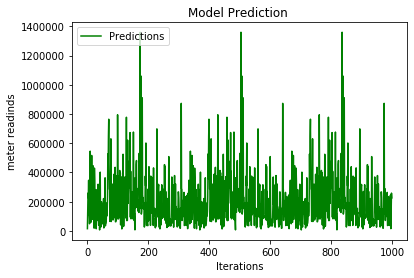

In [121]:
plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

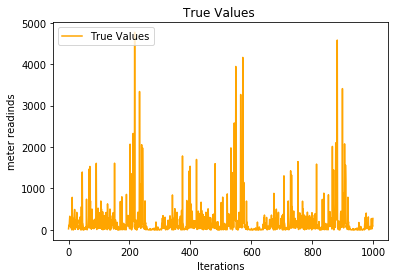

In [199]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

### Per Building plot

In [2]:
from utility import utils
%load_ext autoreload
%autoreload 2

In [ ]:
test_predicted = pd.DataFrame(list(zip(test_building_id,test_timestamp,pred)),columns= ['building_id','timestamp', 'meter_reading' ,] )

In [ ]:
true_readings = pd.DataFrame(list(zip(test_building_id,test_timestamp,list(true_values))),columns= ['building_id','timestamp', 'meter_reading' ,] )

In [ ]:
utils.plot_meter(true_readings,test_predicted,n_plots=5)

Text(0.5, 15.0, 'Iterations')

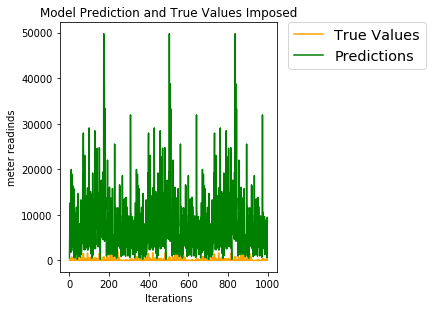

In [76]:
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.plot(predictions,"-g" ,label='Predictions',color='green')

plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='x-large')
plt.tight_layout()

plt.title('Model Prediction and True Values Imposed')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')